In [1]:
%matplotlib inline
import sys, os
import numpy as np
import pyemma as pe
import pyemma
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import mdtraj

In [2]:
sys.path.insert(0,'../')
from torchmdnet2.dataset import ChignolinDataset
from torchmdnet2.nn import CGnet
from torchmdnet2.models import LNNP
from torchmdnet2.utils import LoadFromFile, save_argparse
from torchmdnet2.simulation import Simulation

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

from pytorch_lightning.plugins import DDPPlugin

from torch_geometric.data import DataLoader

from torch.nn import Embedding, Sequential, Linear, ModuleList

In [3]:
device = torch.device('cuda')

# utils

In [4]:
def plot_tica(baseline_model, dataset, lag=10):
    # compute distances all of the beads
    baseline_model.cpu()
    if isinstance(dataset, np.ndarray):
        n_traj, n_samp, n_beads, _ = dataset.shape
        features = []
        for i_traj in range(n_traj):
            _ = baseline_model.geom_feature(torch.from_numpy(dataset[i_traj]))
            feat = baseline_model.geom_feature.distances
            features.append(feat)
    else:
        _ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
        feat = baseline_model.geom_feature.distances

        if 'traj_idx' in dataset.data:
            traj_ids = dataset.data.traj_idx
            n_traj = np.unique(traj_ids).shape[0]
            traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

            features = []
            for i_traj in range(n_traj):
                st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
                features.append(feat[st:nd].numpy())
        else:
            features = feat.numpy()
    
    tica = pe.coordinates.tica(features, lag=lag, dim=2)
    tica_concatenated = np.concatenate(tica.get_output())
    
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    pyemma.plots.plot_feature_histograms(
        tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
    pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
    pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
    for ax in axes.flat[1:]:
        ax.set_xlabel('IC 1')
        ax.set_ylabel('IC 2')
    fig.tight_layout()
    return fig, axes

In [5]:
from torch_geometric.data.data import size_repr

from argparse import Namespace
class Args(Namespace):
    def __init__(self,**kwargs):
        for key, item in kwargs.items():
            self[key] = item
            
    def __getitem__(self, key):
        r"""Gets the data of the attribute :obj:`key`."""
        return getattr(self, key, None)

    def __setitem__(self, key, value):
        """Sets the attribute :obj:`key` to :obj:`value`."""
        setattr(self, key, value)

    @property
    def keys(self):
        r"""Returns all names of graph attributes."""
        keys = [key for key in self.__dict__.keys() if self[key] is not None]
        keys = [key for key in keys if key[:2] != '__' and key[-2:] != '__']
        return keys

    def __len__(self):
        r"""Returns the number of all present attributes."""
        return len(self.keys)

    def __contains__(self, key):
        r"""Returns :obj:`True`, if the attribute :obj:`key` is present in the
        data."""
        return key in self.keys

    def __iter__(self):
        r"""Iterates over all present attributes in the data, yielding their
        attribute names and content."""
        for key in sorted(self.keys):
            yield key, self[key]

    def __call__(self, *keys):
        r"""Iterates over all attributes :obj:`*keys` in the data, yielding
        their attribute names and content.
        If :obj:`*keys` is not given this method will iterative over all
        present attributes."""
        for key in sorted(self.keys) if not keys else keys:
            if key in self:
                yield key, self[key]
                
    def __repr__(self):
        cls = str(self.__class__.__name__)
        has_dict = any([isinstance(item, dict) for _, item in self])

        if not has_dict:
            info = [size_repr(key, item) for key, item in self]
            return '{}({})'.format(cls, ', '.join(info))
        else:
            info = [size_repr(key, item, indent=2) for key, item in self]
            return '{}(\n{}\n)'.format(cls, ',\n'.join(info))


# load and explore the chignolin dataset

In [3]:
dataset = ChignolinDataset('/local/scratch/chignolin/')

In [4]:
loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [5]:
# get the prior model used to modify the forces
baseline_model = dataset.get_baseline_model()

## TICA plot of the reference trajectory

In [10]:
# compute distances all of the beads
_ = baseline_model.geom_feature(dataset.data.pos.reshape((-1, baseline_model.n_beads, 3)))
feat = baseline_model.geom_feature.distances

In [22]:
traj_ids = dataset.data.traj_idx
n_traj = np.unique(traj_ids).shape[0]
traj_strides = np.cumsum([0]+(np.bincount(traj_ids)).tolist(), dtype=int)

features = []
for i_traj in range(n_traj):
    st, nd = traj_strides[i_traj], traj_strides[i_traj+1]
    features.append(feat[st:nd].numpy())


In [29]:
tica = pe.coordinates.tica(features, lag=10, dim=2)
tica_concatenated = np.concatenate(tica.get_output())

calculate covariances:   0%|          | 0/3741 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

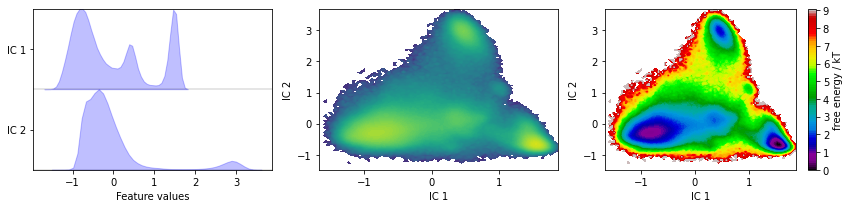

In [31]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(
    tica_concatenated, ['IC {}'.format(i + 1) for i in range(tica.dimension())], ax=axes[0])
pyemma.plots.plot_density(*tica_concatenated[:, :2].T, ax=axes[1], cbar=False, logscale=True)
pyemma.plots.plot_free_energy(*tica_concatenated[:, :2].T, ax=axes[2], legacy=False)
for ax in axes.flat[1:]:
    ax.set_xlabel('IC 1')
    ax.set_ylabel('IC 2')
fig.tight_layout()

# train a CG model

In [12]:
args = Args(**{
    
    'batch_size': 512,
 
    'load_model': None,
    'log_dir': './chign_run/',
    
    'dataset': 'chignolin',
    'dataset_root': '/local/scratch/chignolin/',
    'dataset_stride' : 1,
    
    'derivative': True,
    'distributed_backend': 'ddp',
    'num_nodes': 1,
    'early_stopping_patience': 100,
    'inference_batch_size': 64,
    'label': None,
    
    'activation': 'tanh',
    'embedding_dimension': 128,
    'cutoff_lower': 0.0,
    'cutoff_upper': 30.0,
    'num_filters': 128,
    'num_interactions': 2,
    'num_rbf': 200,
    'trainable_rbf': False,
    'rbf_type': 'expnorm',
    'neighbor_embedding': True,
    
  
    'lr': 1e-4,
    'lr_factor': 0.999,
    'lr_min': 1e-7,
    'lr_patience': 10,
    'lr_warmup_steps': 0,
    
    'ngpus': -1,
    'num_epochs': 100,
    'num_workers': 2,
    'save_interval': 10,
    'seed': 18574,
    'test_interval': 1,
    'test_ratio': 0.05,
    'val_ratio': 0.05,
    'weight_decay': 0.0,
    'precision': 32,
    
    'data' : None,
    'coords' : None,
    'forces' : None,
    'embed' : None,
    'splits' : None,
})

In [13]:
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

model = LNNP(args)
checkpoint_callback = ModelCheckpoint(
    dirpath=args.log_dir,
    monitor='val_loss',
    save_top_k=10, # -1 to save all
    period=args.save_interval,
    filename="{epoch}-{val_loss:.4f}-{test_loss:.4f}"
)
early_stopping = EarlyStopping('val_loss', patience=args.early_stopping_patience)

tb_logger = pl.loggers.TensorBoardLogger(args.log_dir, name='tensorbord', version='')
csv_logger = pl.loggers.CSVLogger(args.log_dir, name='', version='')

ddp_plugin = None
if 'ddp' in args.distributed_backend:
    ddp_plugin = DDPPlugin(find_unused_parameters=False)

trainer = pl.Trainer(
    max_epochs=args.num_epochs,
    gpus=args.ngpus,
    num_nodes=args.num_nodes,
    distributed_backend=args.distributed_backend,
    default_root_dir=args.log_dir,
    auto_lr_find=False,
    resume_from_checkpoint=args.load_model,
    checkpoint_callback=checkpoint_callback,
    callbacks=[early_stopping],
    logger=[tb_logger, csv_logger],
    reload_dataloaders_every_epoch=False,
    enable_pl_optimizer=True,
    precision=args.precision,
    plugins=[ddp_plugin],
)

/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory ./chign_run/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [ ]:
trainer.fit(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
initializing ddp: GLOBAL_RANK: 0, MEMBER: 1/1


train 1681974, val 93443, test 93444


/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Experiment logs directory ./chign_run/ exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  warnings.warn(*args, **kwargs)

  | Name  | Type       | Params
-------------------------------------
0 | model | TorchMD_GN | 275 K 
-------------------------------------
275 K     Trainable params
0         Non-trainable params
275 K     Total params
1.103     Total estimated model params size (MB)
/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Validation sanity check: 0it [00:00, ?it/s]

/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: 0it [00:00, ?it/s]

In [8]:
checkpoint_callback.best_model_path

'/local/git/torchmd-net2/notebooks/test/epoch=89-val_loss=745.0900-test_loss=0.0000.ckpt'

In [18]:
aa = trainer.optimizers[0]
aa.param_groups[0]['lr']

0.00020971520000000012

In [12]:
aa = trainer.lr_schedulers[0]['scheduler']
aa.

In [8]:
# run test set after completing the fit
trainer.test(model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


train 14951, val 1869, test 1869


/local/ssd/miniconda/envs/cg39/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: The dataloader, test dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'avg_loss': 21.610315322875977}
--------------------------------------------------------------------------------


[{'avg_loss': 21.610315322875977}]

# run a simulation

In [5]:
model = LNNP.load_from_checkpoint(
    '/local/git/torchmd-net2/notebooks/test/epoch=89-val_loss=745.0900-test_loss=0.0000.ckpt'
)
chignolin_dataset = ChignolinDataset('/local/scratch/chignolin/')

In [6]:
n_sims = 1000
n_timesteps = 1000
save_interval = 10

In [7]:
baseline_model = chignolin_dataset.get_baseline_model()

In [10]:
ids = np.arange(0, len(chignolin_dataset),len(chignolin_dataset)//n_sims).tolist()
init = chignolin_dataset[ids]
initial_coords = torch.cat([init[i].pos.reshape((1,-1,3)) for i in range(len(init))], dim=0).to(device=device)
initial_coords.requires_grad_()

sim_embeddings = torch.cat([init[i].z.reshape((1,-1)) for i in range(len(init))], dim=0).to(device=device)

chignolin_net = CGnet(model, baseline_model).eval()
chignolin_net.to(device=device)

CGnet(
  (model): LNNP(
    (model): TorchMD_GN(hidden_channels=128, num_filters=128, num_interactions=4, num_rbf=15, rbf_type=expnorm, activation=silu, cutoff_lower=0.0, cutoff_upper=5.0, derivative=True)
  )
  (baseline): BaselineModel(
    (geom_feature): GeometryFeature()
    (priors): Sequential(
      (0): HarmonicLayer()
      (1): HarmonicLayer()
      (2): RepulsionLayer()
    )
  )
)

In [11]:
sim = MySimulation(chignolin_net, initial_coords, sim_embeddings, length=n_timesteps,
                 save_interval=save_interval, beta=baseline_model.beta,
                 save_potential=True, device=device,
                 log_interval=100, log_type='print')

traj = sim.simulate()

Generating 1001 simulations of length 1000 saved at 10-step intervals (Tue Apr 27 14:26:36 2021)
10/100 time points saved (Tue Apr 27 14:26:45 2021)
20/100 time points saved (Tue Apr 27 14:26:53 2021)
30/100 time points saved (Tue Apr 27 14:27:01 2021)
40/100 time points saved (Tue Apr 27 14:27:10 2021)
50/100 time points saved (Tue Apr 27 14:27:18 2021)
60/100 time points saved (Tue Apr 27 14:27:26 2021)
70/100 time points saved (Tue Apr 27 14:27:35 2021)
80/100 time points saved (Tue Apr 27 14:27:43 2021)
90/100 time points saved (Tue Apr 27 14:27:51 2021)
100/100 time points saved (Tue Apr 27 14:27:59 2021)
Done simulating (Tue Apr 27 14:27:59 2021)


calculate covariances:   0%|          | 0/1001 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/1001 [00:00<?, ?it/s]

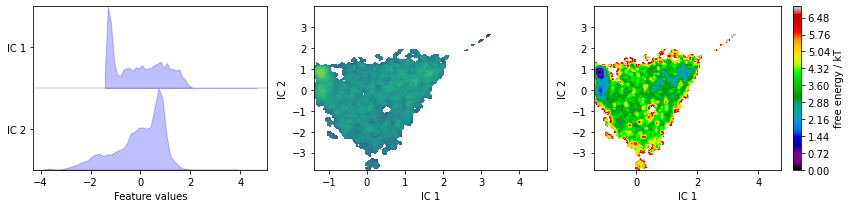

In [32]:
_,_ = plot_tica(baseline_model, traj, lag=1)

calculate covariances:   0%|          | 0/3742 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]

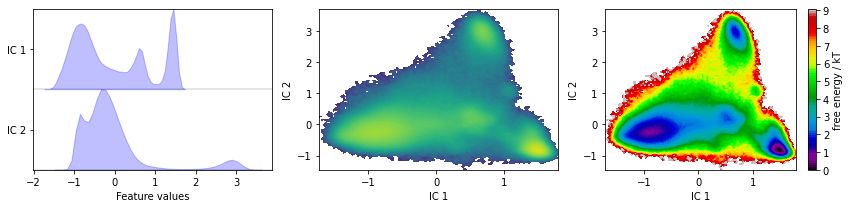

In [21]:
_,_ = plot_tica(baseline_model, chignolin_dataset, lag=10)

calculate covariances:   0%|          | 0/3741 [00:00<?, ?it/s]

getting output of TICA:   0%|          | 0/3744 [00:00<?, ?it/s]